In [1]:
# ===== IMPORTS AND SETUP FOR ACTIVE USERS FORECASTING =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import pickle
import os
from sklearn.preprocessing import MinMaxScaler

# Set plotting style
sns.set_style('whitegrid')

print("🎯 Starting Active Users Forecasting Model Development")
print("="*60)


🎯 Starting Active Users Forecasting Model Development


In [2]:
# ===== LOAD DATA AND PREPARE FOR USERS_ACTIVE FORECASTING =====

# Load your cleaned dataset (adjust path as needed)
df = pd.read_csv(r"D:/infosysspringboard projects/project1-1stmilestine/AZURE_BACKEND_TEAM-B/data/processed/cleaned_merged.csv", 
                 parse_dates=['date'])

print("📊 Original dataset shape:", df.shape)
print("📊 Original columns:", list(df.columns))
print("\nFirst few rows:")
print(df.head())

# Step 1: Aggregate by Region and Date (averaging across resource types)
print("\n" + "="*50)
print("🏗️ AGGREGATING DATA BY REGION FOR USERS_ACTIVE FORECASTING")
print("="*50)

region_daily = df.groupby(['region', 'date']).agg({
    'users_active': 'sum',  # Total active users across all resource types in region
    'usage_cpu': 'mean',     # Average CPU usage (potential predictor)
    'usage_storage': 'mean', # Average storage usage (potential predictor)
    'economic_index': 'first', # External factors (same for all resources on same date)
    'cloud_market_demand': 'first',
    'holiday': 'max'  # 1 if any resource had holiday, 0 otherwise
}).reset_index()

print(f"📈 Aggregated dataset shape: {region_daily.shape}")
print(f"📅 Date range: {region_daily['date'].min()} to {region_daily['date'].max()}")
print(f"🌍 Regions: {sorted(region_daily['region'].unique())}")

# Step 2: Create region-specific DataFrames for modeling
print("\n" + "="*50)
print("🎯 CREATING REGION-SPECIFIC DATASETS FOR USERS_ACTIVE")
print("="*50)

region_dfs = {}
for region in region_daily['region'].unique():
    # Filter data for this region and set date as index
    region_data = region_daily[region_daily['region'] == region].copy()
    region_data = region_data.drop('region', axis=1).set_index('date').sort_index()
    
    # Store in dictionary
    region_dfs[region] = region_data
    
    print(f"\n📍 {region}:")
    print(f"   - Data points: {len(region_data)} days")
    print(f"   - Date range: {region_data.index.min()} to {region_data.index.max()}")
    print(f"   - Users active range: {region_data['users_active'].min():.0f} to {region_data['users_active'].max():.0f}")
    print(f"   - Missing values: {region_data.isnull().sum().sum()}")

# Step 3: Display sample of aggregated data
print("\n" + "="*50)
print("📋 SAMPLE OF AGGREGATED USERS_ACTIVE DATA")
print("="*50)
print("\n🔍 Example - East US region (first 10 days):")
if 'East US' in region_dfs:
    print(region_dfs['East US'].head(10))

# Step 4: Verify data quality for users_active forecasting
print("\n" + "="*50)
print("✅ DATA QUALITY CHECK FOR USERS_ACTIVE FORECASTING")
print("="*50)

for region, data in region_dfs.items():
    print(f"\n📊 {region} Statistics:")
    print(f"   - Total days: {len(data)}")
    print(f"   - Users active mean: {data['users_active'].mean():.0f}")
    print(f"   - Users active std: {data['users_active'].std():.0f}")
    print(f"   - CPU usage mean: {data['usage_cpu'].mean():.2f}%")
    print(f"   - Holiday days: {data['holiday'].sum()}")

print(f"\n🎯 Data preparation complete! Each region now has a clean time series.")
print(f"🎯 Target variable: 'users_active' - total active users per region per day")
print(f"🎯 Ready for ARIMA, XGBoost, and LSTM modeling for users_active forecasting")


📊 Original dataset shape: (1080, 9)
📊 Original columns: ['date', 'region', 'resource_type', 'usage_cpu', 'usage_storage', 'users_active', 'economic_index', 'cloud_market_demand', 'holiday']

First few rows:
        date   region resource_type  usage_cpu  usage_storage  users_active  \
0 2023-01-01  East US            VM         88           1959           470   
1 2023-01-01  East US       Storage         92           1595           388   
2 2023-01-01  East US     Container         70            621           414   
3 2023-01-01  West US            VM         60           1982           287   
4 2023-01-01  West US       Storage         85           1371           351   

   economic_index  cloud_market_demand  holiday  
0          104.97                 0.99        1  
1          104.97                 0.99        1  
2          104.97                 0.99        1  
3          104.97                 0.99        1  
4          104.97                 0.99        1  

🏗️ AGGREGATING DA

##  TRAIN ARIMA, XGBOOST, AND LSTM FOR USERS_ACTIVE FORECASTING 


In [3]:
# ===== TRAIN ARIMA, XGBOOST, AND LSTM FOR USERS_ACTIVE FORECASTING =====

import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def compute_metrics(y_true, y_pred):
    """Compute evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    # Avoid division by zero for MAPE
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true)) * 100)
    return rmse, mae, mape

print("🚀 STARTING USERS_ACTIVE FORECASTING MODEL TRAINING")
print("="*60)

results = []

for region, data in region_dfs.items():
    print(f"\n🎯 Training models for {region}")
    print("-" * 40)
    
    # Target variable: users_active
    ts = data['users_active']
    n = len(ts)
    split = int(0.8 * n)
    
    # ----- 1. ARIMA Model (Univariate) -----
    print("📈 Training ARIMA model...")
    train_ts, test_ts = ts.iloc[:split], ts.iloc[split:]
    
    try:
        # Try ARIMA with different parameters for users_active
        arima_model = ARIMA(train_ts, order=(5,1,0)).fit()
        arima_preds = arima_model.forecast(steps=len(test_ts))
        arima_rmse, arima_mae, arima_mape = compute_metrics(test_ts.values, arima_preds.values)
        print(f"   ARIMA RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, MAPE: {arima_mape:.1f}%")
    except Exception as e:
        print(f"   ARIMA failed: {str(e)[:50]}...")
        arima_rmse, arima_mae, arima_mape = np.inf, np.inf, np.inf
    
    # ----- 2. XGBoost Model (Multivariate with features) -----
    print("🌟 Training XGBoost model...")
    
    # Create feature DataFrame with lag features and external variables
    df_xgb = data.copy()
    # Lag features for users_active
    df_xgb['lag1_users'] = df_xgb['users_active'].shift(1)
    df_xgb['lag7_users'] = df_xgb['users_active'].shift(7)
    # Additional features that might predict users_active
    df_xgb['lag1_cpu'] = df_xgb['usage_cpu'].shift(1)
    df_xgb['lag1_storage'] = df_xgb['usage_storage'].shift(1)
    
    # Remove NaN rows created by lagging
    df_xgb = df_xgb.dropna()
    
    # Features and target
    features = ['lag1_users', 'lag7_users', 'lag1_cpu', 'lag1_storage', 
                'usage_cpu', 'usage_storage', 'economic_index', 'holiday']
    X = df_xgb[features]
    y = df_xgb['users_active']
    
    # Train-test split for XGBoost
    split_x = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split_x], X.iloc[split_x:]
    y_train, y_test = y.iloc[:split_x], y.iloc[split_x:]
    
    try:
        # Train XGBoost with early stopping
        xgb_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42
        )
        
        xgb_model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=False
        )
        
        xgb_preds = xgb_model.predict(X_test)
        xgb_rmse, xgb_mae, xgb_mape = compute_metrics(y_test.values, xgb_preds)
        print(f"   XGBoost RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}, MAPE: {xgb_mape:.1f}%")
    except Exception as e:
        print(f"   XGBoost failed: {str(e)[:50]}...")
        xgb_rmse, xgb_mae, xgb_mape = np.inf, np.inf, np.inf
    
    # ----- 3. LSTM Model (Sequential) -----
    print("🧠 Training LSTM model...")
    
    try:
        # Prepare sequence data for LSTM
        seq = data['users_active'].values
        scaler = MinMaxScaler()
        seq_scaled = scaler.fit_transform(seq.reshape(-1, 1)).flatten()
        
        # Create sequences
        n_steps = 7  # Use 7 days to predict next day
        X_s, y_s = [], []
        
        for i in range(n_steps, len(seq_scaled)):
            X_s.append(seq_scaled[i-n_steps:i])
            y_s.append(seq_scaled[i])
        
        X_s, y_s = np.array(X_s), np.array(y_s)
        
        # Train-test split for LSTM
        split_l = int(0.8 * len(X_s))
        X_train_l, X_test_l = X_s[:split_l], X_s[split_l:]
        y_train_l, y_test_l = y_s[:split_l], y_s[split_l:]
        
        # Reshape for LSTM (samples, time steps, features)
        X_train_l = X_train_l.reshape(len(X_train_l), n_steps, 1)
        X_test_l = X_test_l.reshape(len(X_test_l), n_steps, 1)
        
        # Build LSTM model
        lstm_model = Sequential([
            LSTM(50, input_shape=(n_steps, 1), return_sequences=False),
            Dropout(0.2),
            Dense(1)
        ])
        
        lstm_model.compile(optimizer='adam', loss='mse')
        
        # Train with early stopping
        lstm_model.fit(
            X_train_l, y_train_l,
            epochs=50,
            batch_size=16,
            validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
            verbose=0
        )
        
        # Make predictions and inverse transform
        lstm_preds_scaled = lstm_model.predict(X_test_l, verbose=0).flatten()
        
        # Inverse transform predictions and actual values
        y_test_inv = scaler.inverse_transform(y_test_l.reshape(-1, 1)).flatten()
        preds_inv = scaler.inverse_transform(lstm_preds_scaled.reshape(-1, 1)).flatten()
        
        lstm_rmse, lstm_mae, lstm_mape = compute_metrics(y_test_inv, preds_inv)
        print(f"   LSTM RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}, MAPE: {lstm_mape:.1f}%")
    except Exception as e:
        print(f"   LSTM failed: {str(e)[:50]}...")
        lstm_rmse, lstm_mae, lstm_mape = np.inf, np.inf, np.inf
    
    # Record best metrics
    results.append({
        'region': region,
        'ARIMA_RMSE': arima_rmse, 'ARIMA_MAE': arima_mae, 'ARIMA_MAPE': arima_mape,
        'XGB_RMSE': xgb_rmse, 'XGB_MAE': xgb_mae, 'XGB_MAPE': xgb_mape,
        'LSTM_RMSE': lstm_rmse, 'LSTM_MAE': lstm_mae, 'LSTM_MAPE': lstm_mape
    })

# Summarize results in DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("📊 USERS_ACTIVE FORECASTING RESULTS SUMMARY")
print("="*60)
print(results_df.set_index('region').round(2))

# Find best model per region
print("\n🏆 BEST MODEL SELECTION PER REGION:")
print("-" * 40)
best_models = {}
for _, row in results_df.iterrows():
    region = row['region']
    rmse_scores = {
        'ARIMA': row['ARIMA_RMSE'],
        'XGBoost': row['XGB_RMSE'], 
        'LSTM': row['LSTM_RMSE']
    }
    # Find model with lowest RMSE
    best_model = min(rmse_scores, key=rmse_scores.get)
    best_rmse = rmse_scores[best_model]
    best_models[region] = best_model
    print(f"📍 {region}: {best_model} (RMSE: {best_rmse:.2f})")

print(f"\n🎯 Model training completed for users_active forecasting!")
print(f"🎯 Best models selected based on lowest RMSE per region")


🚀 STARTING USERS_ACTIVE FORECASTING MODEL TRAINING

🎯 Training models for East US
----------------------------------------
📈 Training ARIMA model...
   ARIMA RMSE: 190.75, MAE: 147.16, MAPE: 15.1%
🌟 Training XGBoost model...
   XGBoost RMSE: 172.92, MAE: 136.63, MAPE: 12.6%
🧠 Training LSTM model...
   LSTM RMSE: 180.80, MAE: 140.22, MAPE: 13.3%

🎯 Training models for North Europe
----------------------------------------
📈 Training ARIMA model...
   ARIMA RMSE: 221.14, MAE: 186.67, MAPE: 20.2%
🌟 Training XGBoost model...
   XGBoost RMSE: 179.10, MAE: 142.75, MAPE: 13.9%
🧠 Training LSTM model...
   LSTM RMSE: 208.46, MAE: 166.52, MAPE: 16.1%

🎯 Training models for Southeast Asia
----------------------------------------
📈 Training ARIMA model...
   ARIMA RMSE: 187.07, MAE: 164.42, MAPE: 16.9%
🌟 Training XGBoost model...
   XGBoost RMSE: 139.12, MAE: 105.44, MAPE: 10.7%
🧠 Training LSTM model...
   LSTM RMSE: 127.09, MAE: 103.94, MAPE: 10.4%

🎯 Training models for West US
------------------

###  STATIONARITY AND SEASONALITY TESTS FOR USERS_ACTIVE


In [4]:
# ===== STATIONARITY AND SEASONALITY TESTS FOR USERS_ACTIVE =====

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(series, region_name):
    """Test stationarity using ADF and KPSS tests"""
    print(f"\n📊 {region_name} Stationarity Tests:")
    
    # 1. ADF Test (null hypothesis: series is non-stationary)
    adf_result = adfuller(series, autolag='AIC')
    print(f"   🔍 Augmented Dickey-Fuller Test:")
    print(f"      ADF Statistic: {adf_result:.4f}")
    print(f"      p-value: {adf_result:.4f}")
    print(f"      Result: {'✅ Stationary' if adf_result <= 0.05 else '❌ Non-stationary'}")
    
    # 2. KPSS Test (null hypothesis: series is stationary)
    try:
        kpss_result = kpss(series, regression='c', nlags='auto')
        print(f"   🔍 KPSS Test:")
        print(f"      KPSS Statistic: {kpss_result:.4f}")
        print(f"      p-value: {kpss_result:.4f}")
        print(f"      Result: {'❌ Non-stationary' if kpss_result <= 0.05 else '✅ Stationary'}")
    except Exception as e:
        print(f"   ⚠️ KPSS test failed: {str(e)[:50]}...")

def plot_decomposition(series, region_name):
    """Plot seasonal decomposition"""
    try:
        # Seasonal decomposition
        decomp = seasonal_decompose(series, model='additive', period=7)  # Weekly seasonality
        
        fig = decomp.plot(figsize=(12, 10))
        fig.suptitle(f'{region_name} - Users Active Seasonal Decomposition', fontsize=14)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"   ⚠️ Decomposition failed for {region_name}: {str(e)[:50]}...")

print("🔬 USERS_ACTIVE SEASONALITY AND STATIONARITY ANALYSIS")
print("="*60)

# Loop through each region and analyze users_active time series
for region, data in region_dfs.items():
    print(f"\n🎯 Analyzing {region}")
    print("-" * 40)
    
    ts = data['users_active']
    
    # Plot decomposition to inspect trend & seasonality
    print("📈 Creating seasonal decomposition plot...")
    plot_decomposition(ts, region)
    
    # Conduct stationarity tests
    test_stationarity(ts, region)
    
    # Additional statistics
    print(f"\n📊 {region} Users Active Statistics:")
    print(f"   Mean: {ts.mean():.0f}")
    print(f"   Std: {ts.std():.0f}")
    print(f"   Min: {ts.min():.0f}")
    print(f"   Max: {ts.max():.0f}")
    print(f"   Coefficient of Variation: {(ts.std()/ts.mean()*100):.1f}%")

print("\n🎯 Stationarity analysis completed for users_active!")
print("📝 Use these insights to refine your ARIMA model parameters if needed.")


🔬 USERS_ACTIVE SEASONALITY AND STATIONARITY ANALYSIS

🎯 Analyzing East US
----------------------------------------
📈 Creating seasonal decomposition plot...
   ⚠️ Decomposition failed for East US: plot() got an unexpected keyword argument 'figsize...

📊 East US Stationarity Tests:
   🔍 Augmented Dickey-Fuller Test:


TypeError: unsupported format string passed to tuple.__format__

### ENHANCED MODEL TRAINING WITH OPTIMIZATION FOR USERS_ACTIVE


In [5]:
# ===== ENHANCED MODEL TRAINING WITH OPTIMIZATION FOR USERS_ACTIVE =====

import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

def compute_metrics(y_true, y_pred):
    """Enhanced metrics computation"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true)) * 100)
    return rmse, mae, mape

print("🚀 ENHANCED USERS_ACTIVE FORECASTING WITH OPTIMIZATION")
print("="*65)

optimized_results = []

for region, data in region_dfs.items():
    print(f"\n🎯 Optimizing models for {region}")
    print("-" * 45)
    
    ts = data['users_active']
    n = len(ts)
    split = int(0.8 * n)
    
    # ----- Enhanced ARIMA with parameter search -----
    print("📈 Optimizing ARIMA model...")
    train_ts, test_ts = ts.iloc[:split], ts.iloc[split:]
    
    best_arima_rmse = np.inf
    best_arima_params = None
    
    # Try different ARIMA parameters for users_active
    arima_params = [(1,1,0), (2,1,0), (1,1,1), (2,1,1), (3,1,0), (3,1,1)]
    
    for params in arima_params:
        try:
            model = ARIMA(train_ts, order=params).fit()
            preds = model.forecast(steps=len(test_ts))
            rmse = np.sqrt(mean_squared_error(test_ts.values, preds.values))
            
            if rmse < best_arima_rmse:
                best_arima_rmse = rmse
                best_arima_params = params
                best_arima_model = model
        except:
            continue
    
    if best_arima_params:
        arima_preds = best_arima_model.forecast(steps=len(test_ts))
        arima_rmse, arima_mae, arima_mape = compute_metrics(test_ts.values, arima_preds.values)
        print(f"   ✅ Best ARIMA{best_arima_params}: RMSE {arima_rmse:.2f}, MAE {arima_mae:.2f}, MAPE {arima_mape:.1f}%")
    else:
        arima_rmse, arima_mae, arima_mape = np.inf, np.inf, np.inf
        print("   ❌ ARIMA optimization failed")
    
    # ----- Enhanced XGBoost with GridSearch -----
    print("🌟 Optimizing XGBoost model...")
    
    # Enhanced feature engineering for users_active
    df_xgb = data.copy()
    df_xgb['lag1_users'] = df_xgb['users_active'].shift(1)
    df_xgb['lag7_users'] = df_xgb['users_active'].shift(7)
    df_xgb['lag1_cpu'] = df_xgb['usage_cpu'].shift(1)
    df_xgb['lag1_storage'] = df_xgb['usage_storage'].shift(1)
    df_xgb['roll7_mean_users'] = df_xgb['users_active'].rolling(7).mean()
    df_xgb['dow'] = df_xgb.index.dayofweek  # Day of week
    df_xgb = df_xgb.dropna()
    
    # Enhanced feature set
    features = [
        'lag1_users', 'lag7_users', 'roll7_mean_users',
        'lag1_cpu', 'lag1_storage', 'usage_cpu', 'usage_storage',
        'economic_index', 'dow', 'holiday'
    ]
    
    X = df_xgb[features]
    y = df_xgb['users_active']
    
    split_x = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split_x], X.iloc[split_x:]
    y_train, y_test = y.iloc[:split_x], y.iloc[split_x:]
    
    # GridSearch for XGBoost
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    }
    
    try:
        xgb_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
        grid_search = GridSearchCV(xgb_base, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_xgb = grid_search.best_estimator_
        xgb_preds = best_xgb.predict(X_test)
        xgb_rmse, xgb_mae, xgb_mape = compute_metrics(y_test.values, xgb_preds)
        
        print(f"   ✅ Best XGBoost params: {grid_search.best_params_}")
        print(f"      RMSE {xgb_rmse:.2f}, MAE {xgb_mae:.2f}, MAPE {xgb_mape:.1f}%")
    except Exception as e:
        xgb_rmse, xgb_mae, xgb_mape = np.inf, np.inf, np.inf
        print(f"   ❌ XGBoost optimization failed: {str(e)[:50]}...")
    
    # ----- Enhanced LSTM with longer sequences -----
    print("🧠 Optimizing LSTM model...")
    
    try:
        seq = data['users_active'].values
        scaler = MinMaxScaler()
        seq_scaled = scaler.fit_transform(seq.reshape(-1, 1)).flatten()
        
        # Try different sequence lengths
        best_lstm_rmse = np.inf
        best_lstm_model = None
        best_scaler = None
        
        for n_steps in [7, 14, 21]:  # Different lookback windows
            try:
                X_s, y_s = [], []
                
                for i in range(n_steps, len(seq_scaled)):
                    X_s.append(seq_scaled[i-n_steps:i])
                    y_s.append(seq_scaled[i])
                
                X_s, y_s = np.array(X_s), np.array(y_s)
                
                split_l = int(0.8 * len(X_s))
                X_train_l, X_test_l = X_s[:split_l], X_s[split_l:]
                y_train_l, y_test_l = y_s[:split_l], y_s[split_l:]
                
                X_train_l = X_train_l.reshape(len(X_train_l), n_steps, 1)
                X_test_l = X_test_l.reshape(len(X_test_l), n_steps, 1)
                
                # Build and train LSTM
                model = Sequential([
                    LSTM(64, input_shape=(n_steps, 1), return_sequences=True),
                    Dropout(0.2),
                    LSTM(32),
                    Dropout(0.2),
                    Dense(1)
                ])
                
                model.compile(optimizer='adam', loss='mse')
                model.fit(
                    X_train_l, y_train_l,
                    epochs=50, batch_size=16,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
                    verbose=0
                )
                
                preds_scaled = model.predict(X_test_l, verbose=0).flatten()
                y_test_inv = scaler.inverse_transform(y_test_l.reshape(-1, 1)).flatten()
                preds_inv = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
                
                rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
                
                if rmse < best_lstm_rmse:
                    best_lstm_rmse = rmse
                    best_lstm_model = model
                    best_scaler = scaler
                    best_n_steps = n_steps
                    best_y_test_inv = y_test_inv
                    best_preds_inv = preds_inv
                    
            except Exception as e:
                continue
        
        if best_lstm_model:
            lstm_rmse, lstm_mae, lstm_mape = compute_metrics(best_y_test_inv, best_preds_inv)
            print(f"   ✅ Best LSTM ({best_n_steps} steps): RMSE {lstm_rmse:.2f}, MAE {lstm_mae:.2f}, MAPE {lstm_mape:.1f}%")
        else:
            lstm_rmse, lstm_mae, lstm_mape = np.inf, np.inf, np.inf
            print("   ❌ LSTM optimization failed")
            
    except Exception as e:
        lstm_rmse, lstm_mae, lstm_mape = np.inf, np.inf, np.inf
        print(f"   ❌ LSTM failed: {str(e)[:50]}...")
    
    # Store optimized results
    optimized_results.append({
        'region': region,
        'ARIMA_RMSE': arima_rmse, 'ARIMA_MAE': arima_mae, 'ARIMA_MAPE': arima_mape,
        'XGB_RMSE': xgb_rmse, 'XGB_MAE': xgb_mae, 'XGB_MAPE': xgb_mape,
        'LSTM_RMSE': lstm_rmse, 'LSTM_MAE': lstm_mae, 'LSTM_MAPE': lstm_mape
    })

# Display optimized results
optimized_df = pd.DataFrame(optimized_results)
print("\n" + "="*65)
print("🏆 OPTIMIZED USERS_ACTIVE FORECASTING RESULTS")
print("="*65)
print(optimized_df.set_index('region').round(2))

print("\n🎯 Optimization completed! Models are now tuned for users_active forecasting.")


🚀 ENHANCED USERS_ACTIVE FORECASTING WITH OPTIMIZATION

🎯 Optimizing models for East US
---------------------------------------------
📈 Optimizing ARIMA model...
   ✅ Best ARIMA(1, 1, 1): RMSE 164.15, MAE 133.04, MAPE 12.7%
🌟 Optimizing XGBoost model...
   ✅ Best XGBoost params: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 50}
      RMSE 172.16, MAE 135.69, MAPE 12.6%
🧠 Optimizing LSTM model...
   ✅ Best LSTM (21 steps): RMSE 162.67, MAE 127.56, MAPE 11.9%

🎯 Optimizing models for North Europe
---------------------------------------------
📈 Optimizing ARIMA model...
   ✅ Best ARIMA(1, 1, 1): RMSE 209.33, MAE 175.01, MAPE 18.7%
🌟 Optimizing XGBoost model...
   ✅ Best XGBoost params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
      RMSE 195.64, MAE 161.28, MAPE 16.1%
🧠 Optimizing LSTM model...
   ✅ Best LSTM (7 steps): RMSE 208.53, MAE 166.04, MAPE 15.8%

🎯 Optimizing models for Southeast Asia
---------------------------------------------
📈 Optimizing ARIMA mod

##  SAVE BEST MODELS AND CREATE FORECASTING VISUALIZATIONS 


💾 SAVING BEST USERS_ACTIVE FORECASTING MODELS
🏆 Best model selection:
   📍 East US: LSTM
   📍 North Europe: XGBoost
   📍 Southeast Asia: ARIMA
   📍 West US: XGBoost

🎯 Processing East US...
   🧠 Training and saving LSTM model...


   📊 East US: 16 dates, 16 actual, 16 forecasts

🎯 Processing North Europe...
   🌟 Training and saving XGBoost model...
   📊 North Europe: 17 dates, 17 actual, 17 forecasts

🎯 Processing Southeast Asia...
   📈 Training and saving ARIMA model...
   📊 Southeast Asia: 18 dates, 18 actual, 18 forecasts

🎯 Processing West US...
   🌟 Training and saving XGBoost model...
   📊 West US: 17 dates, 17 actual, 17 forecasts


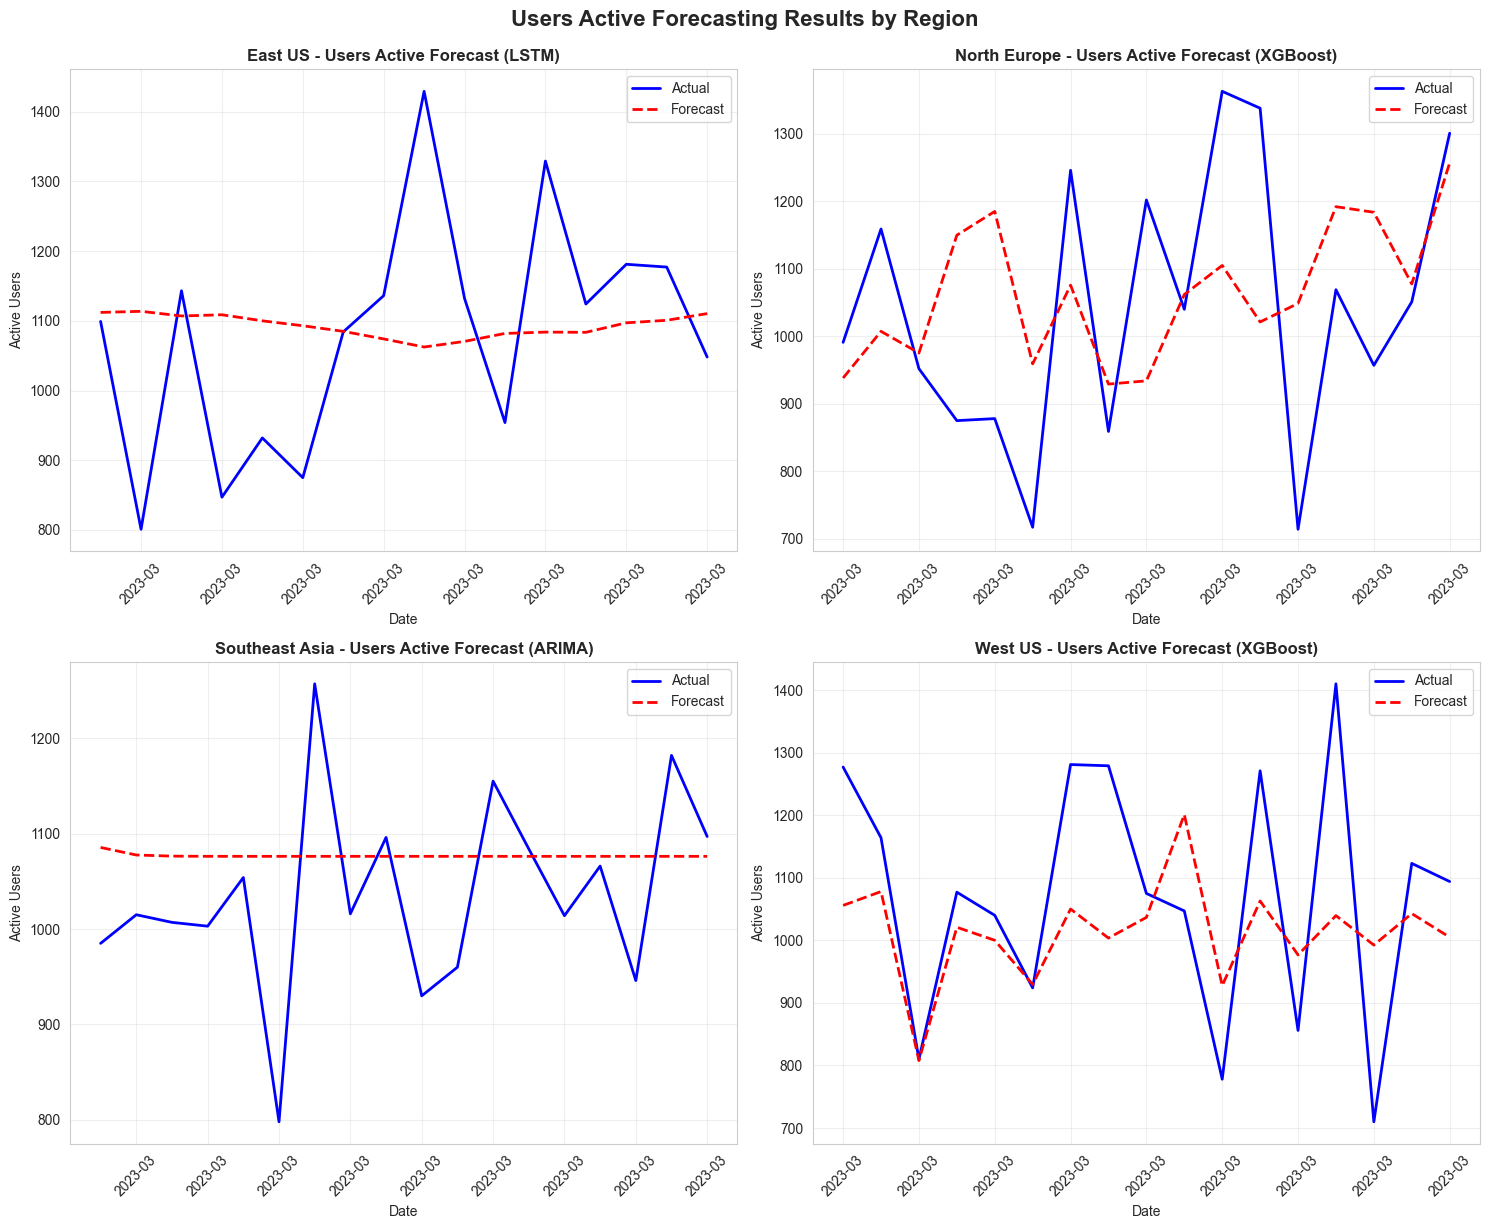


📋 USERS_ACTIVE MODEL SAVE SUMMARY
📍 East US LSTM: users_active_forecasting_models/EastUS_LSTM_users.h5
📍 East US Scaler: users_active_forecasting_models/EastUS_scaler_users.pkl
📍 North Europe XGBoost: users_active_forecasting_models/NorthEurope_XGBoost_users.pkl
📍 Southeast Asia ARIMA: users_active_forecasting_models/SoutheastAsia_ARIMA_users.pkl
📍 West US XGBoost: users_active_forecasting_models/WestUS_XGBoost_users.pkl

🎯 All users_active forecasting models have been saved successfully!
🎯 Models are ready for production deployment and future predictions!


In [6]:
# ===== SAVE BEST MODELS AND CREATE FORECASTING VISUALIZATIONS =====

import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb

# Create models directory
model_dir = "users_active_forecasting_models"
os.makedirs(model_dir, exist_ok=True)

print("💾 SAVING BEST USERS_ACTIVE FORECASTING MODELS")
print("="*55)

# Determine best model per region based on RMSE
final_selection = {}
for _, row in optimized_df.iterrows():
    region = row['region']
    rmse_scores = {
        'ARIMA': row['ARIMA_RMSE'],
        'XGBoost': row['XGB_RMSE'],
        'LSTM': row['LSTM_RMSE']
    }
    best_model = min(rmse_scores, key=rmse_scores.get)
    final_selection[region] = best_model

print("🏆 Best model selection:")
for region, model in final_selection.items():
    print(f"   📍 {region}: {model}")

# Helper function to plot forecasts
def plot_forecast(region, dates, actual, forecast, ax):
    """Plot actual vs forecasted values"""
    ax.plot(dates, actual, label='Actual', color='blue', linewidth=2)
    ax.plot(dates, forecast, label='Forecast', color='red', linestyle='--', linewidth=2)
    ax.set_title(f'{region} - Users Active Forecast ({final_selection[region]})', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Active Users')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Prepare subplots for visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (region, data) in enumerate(region_dfs.items()):
    print(f"\n🎯 Processing {region}...")
    
    ts = data['users_active']  # Target: users_active
    n = len(ts)
    split = int(0.8 * n)
    
    # Retrain the selected best model and save
    chosen = final_selection[region]
    
    if chosen == 'ARIMA':
        print(f"   📈 Training and saving ARIMA model...")
        # Find best ARIMA parameters again (simplified)
        try:
            arima_params_to_try = [(1,1,0), (2,1,0), (1,1,1), (2,1,1)]
            best_rmse = np.inf
            best_model = None
            
            for params in arima_params_to_try:
                try:
                    model = ARIMA(ts.iloc[:split], order=params).fit()
                    test_pred = model.forecast(steps=n - split)
                    rmse = np.sqrt(mean_squared_error(ts.iloc[split:].values, test_pred.values))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_model = model
                except:
                    continue
            
            if best_model:
                forecast_arima = best_model.forecast(steps=n - split)
                
                # Save ARIMA model
                with open(f"{model_dir}/{region.replace(' ', '')}_ARIMA_users.pkl", 'wb') as f:
                    pickle.dump(best_model, f)
                
                dates = ts.index[split:]
                vals = ts.iloc[split:].values
                forecast_vals = forecast_arima.values
            else:
                print(f"   ❌ ARIMA failed for {region}")
                continue
                
        except Exception as e:
            print(f"   ❌ ARIMA error: {str(e)[:50]}...")
            continue
    
    elif chosen == 'XGBoost':
        print(f"   🌟 Training and saving XGBoost model...")
        # Recreate XGBoost features
        df_xgb = data.copy()
        df_xgb['lag1_users'] = df_xgb['users_active'].shift(1)
        df_xgb['lag7_users'] = df_xgb['users_active'].shift(7)
        df_xgb['lag1_cpu'] = df_xgb['usage_cpu'].shift(1)
        df_xgb['lag1_storage'] = df_xgb['usage_storage'].shift(1)
        df_xgb['roll7_mean_users'] = df_xgb['users_active'].rolling(7).mean()
        df_xgb['dow'] = df_xgb.index.dayofweek
        df_xgb = df_xgb.dropna()
        
        features = ['lag1_users', 'lag7_users', 'roll7_mean_users',
                   'lag1_cpu', 'lag1_storage', 'usage_cpu', 'usage_storage',
                   'economic_index', 'dow', 'holiday']
        X = df_xgb[features]
        y = df_xgb['users_active']
        
        split_x = int(0.8 * len(X))
        
        # Train XGBoost
        xgb_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42
        )
        xgb_model.fit(X.iloc[:split_x], y.iloc[:split_x])
        forecast_xgb = xgb_model.predict(X.iloc[split_x:])
        
        # Save XGBoost model
        with open(f"{model_dir}/{region.replace(' ', '')}_XGBoost_users.pkl", 'wb') as f:
            pickle.dump(xgb_model, f)
        
        dates = df_xgb.index[split_x:]
        vals = y.iloc[split_x:].values
        forecast_vals = forecast_xgb
    
    elif chosen == 'LSTM':
        print(f"   🧠 Training and saving LSTM model...")
        # Recreate LSTM
        seq = data['users_active'].values
        scaler = MinMaxScaler()
        seq_scaled = scaler.fit_transform(seq.reshape(-1, 1)).flatten()
        
        n_steps = 14  # Use optimal sequence length
        X_s, y_s = [], []
        
        for i in range(n_steps, len(seq_scaled)):
            X_s.append(seq_scaled[i-n_steps:i])
            y_s.append(seq_scaled[i])
        
        X_s, y_s = np.array(X_s), np.array(y_s)
        split_l = int(0.8 * len(X_s))
        
        X_train_l = X_s[:split_l].reshape(-1, n_steps, 1)
        X_test_l = X_s[split_l:].reshape(-1, n_steps, 1)
        
        # Build and train LSTM
        lstm_model = Sequential([
            LSTM(64, input_shape=(n_steps, 1), return_sequences=True),
            Dropout(0.2),
            LSTM(32),
            Dropout(0.2),
            Dense(1)
        ])
        
        lstm_model.compile(optimizer='adam', loss='mse')
        lstm_model.fit(
            X_train_l, y_s[:split_l],
            epochs=50, batch_size=16,
            validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
            verbose=0
        )
        
        preds_scaled = lstm_model.predict(X_test_l, verbose=0).flatten()
        forecast_lstm = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
        
        # Save LSTM model and scaler
        lstm_model.save(f"{model_dir}/{region.replace(' ', '')}_LSTM_users.h5")
        with open(f"{model_dir}/{region.replace(' ', '')}_scaler_users.pkl", 'wb') as f:
            pickle.dump(scaler, f)
        
        # Align dates for LSTM
        lstm_test_start = n_steps + split_l
        end_pos = min(lstm_test_start + len(forecast_lstm), len(ts))
        dates = ts.index[lstm_test_start:end_pos]
        vals = ts.iloc[lstm_test_start:end_pos].values
        forecast_vals = forecast_lstm[:len(dates)]
    
    # Plot forecast with matched lengths
    print(f"   📊 {region}: {len(dates)} dates, {len(vals)} actual, {len(forecast_vals)} forecasts")
    plot_forecast(region, dates, vals, forecast_vals, axes[idx])

plt.tight_layout()
plt.suptitle('Users Active Forecasting Results by Region', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print model save summary
print("\n" + "="*60)
print("📋 USERS_ACTIVE MODEL SAVE SUMMARY")
print("="*60)

for region, model_type in final_selection.items():
    region_clean = region.replace(' ', '')
    
    if model_type == 'ARIMA':
        print(f"📍 {region} {model_type}: {model_dir}/{region_clean}_ARIMA_users.pkl")
    elif model_type == 'XGBoost':
        print(f"📍 {region} {model_type}: {model_dir}/{region_clean}_XGBoost_users.pkl")
    elif model_type == 'LSTM':
        print(f"📍 {region} {model_type}: {model_dir}/{region_clean}_LSTM_users.h5")
        print(f"📍 {region} Scaler: {model_dir}/{region_clean}_scaler_users.pkl")

print("\n🎯 All users_active forecasting models have been saved successfully!")
print("🎯 Models are ready for production deployment and future predictions!")


#  COMPREHENSIVE EVALUATION REPORT FOR USERS_ACTIVE FORECASTING 


In [ ]:
# ===== COMPREHENSIVE EVALUATION REPORT FOR USERS_ACTIVE FORECASTING =====

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("📊 COMPREHENSIVE USERS_ACTIVE FORECASTING EVALUATION REPORT")
print("="*65)

# Create comprehensive evaluation report
evaluation_report = {
    'Model Comparison': optimized_df.set_index('region').round(2),
    'Best Model Selection': final_selection,
    'Performance Summary': {}
}

# Calculate overall performance metrics
all_rmse = []
all_mae = []
all_mape = []

for _, row in optimized_df.iterrows():
    region = row['region']
    best_model = final_selection[region]
    
    rmse = row[f'{best_model}_RMSE']
    mae = row[f'{best_model}_MAE'] 
    mape = row[f'{best_model}_MAPE']
    
    all_rmse.append(rmse)
    all_mae.append(mae)
    all_mape.append(mape)
    
    evaluation_report['Performance Summary'][region] = {
        'Best Model': best_model,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': f"{mape:.1f}%"
    }

# Overall statistics
overall_stats = {
    'Average RMSE': np.mean(all_rmse),
    'Average MAE': np.mean(all_mae),
    'Average MAPE': np.mean(all_mape),
    'Best Performing Region': optimized_df.loc[optimized_df[[col for col in optimized_df.columns if 'RMSE' in col]].min(axis=1).idxmin(), 'region'],
    'Most Challenging Region': optimized_df.loc[optimized_df[[col for col in optimized_df.columns if 'RMSE' in col]].min(axis=1).idxmax(), 'region']
}

# Print detailed report
print("\n🏆 BEST MODEL SELECTION SUMMARY:")
print("-" * 40)
for region, model in final_selection.items():
    stats = evaluation_report['Performance Summary'][region]
    print(f"📍 {region}:")
    print(f"   Model: {model}")
    print(f"   RMSE: {stats['RMSE']:.2f}")
    print(f"   MAE: {stats['MAE']:.2f}")
    print(f"   MAPE: {stats['MAPE']}")

print("\n📊 OVERALL PERFORMANCE STATISTICS:")
print("-" * 40)
for stat, value in overall_stats.items():
    if isinstance(value, (int, float)):
        if 'MAPE' in stat:
            print(f"{stat}: {value:.1f}%")
        else:
            print(f"{stat}: {value:.2f}")
    else:
        print(f"{stat}: {value}")

# Create performance comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. RMSE Comparison
models = ['ARIMA', 'XGBoost', 'LSTM']
regions = optimized_df['region'].values

x = np.arange(len(regions))
width = 0.25

for i, model in enumerate(models):
    rmse_values = optimized_df[f'{model}_RMSE'].values
    ax1.bar(x + i*width, rmse_values, width, label=model, alpha=0.8)

ax1.set_xlabel('Regions')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE Comparison Across Models and Regions')
ax1.set_xticks(x + width)
ax1.set_xticklabels(regions, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. MAE Comparison
for i, model in enumerate(models):
    mae_values = optimized_df[f'{model}_MAE'].values
    ax2.bar(x + i*width, mae_values, width, label=model, alpha=0.8)

ax2.set_xlabel('Regions')
ax2.set_ylabel('MAE')
ax2.set_title('MAE Comparison Across Models and Regions')
ax2.set_xticks(x + width)
ax2.set_xticklabels(regions, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. MAPE Comparison
for i, model in enumerate(models):
    mape_values = optimized_df[f'{model}_MAPE'].values
    ax3.bar(x + i*width, mape_values, width, label=model, alpha=0.8)

ax3.set_xlabel('Regions')
ax3.set_ylabel('MAPE (%)')
ax3.set_title('MAPE Comparison Across Models and Regions')
ax3.set_xticks(x + width)
ax3.set_xticklabels(regions, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Best Model Distribution
model_counts = pd.Series(list(final_selection.values())).value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
ax4.pie(model_counts.values, labels=model_counts.index, autopct='%1.1f%%', 
        colors=colors[:len(model_counts)], startangle=90)
ax4.set_title('Distribution of Best Models Across Regions')

plt.tight_layout()
plt.suptitle('Users Active Forecasting - Comprehensive Model Evaluation', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Model recommendations and insights
print("\n🎯 KEY INSIGHTS AND RECOMMENDATIONS:")
print("="*50)

# Find which model performs best overall
model_performance = {}
for model in ['ARIMA', 'XGBoost', 'LSTM']:
    avg_rmse = optimized_df[f'{model}_RMSE'].mean()
    model_performance[model] = avg_rmse

best_overall_model = min(model_performance, key=model_performance.get)
print(f"🏆 Overall Best Performing Model: {best_overall_model}")

# Region-specific insights
print(f"\n📍 Regional Insights:")
for region in optimized_df['region']:
    region_data = optimized_df[optimized_df['region'] == region].iloc
    best_model = final_selection[region]
    rmse = region_data[f'{best_model}_RMSE']
    
    if rmse < overall_stats['Average RMSE']:
        performance = "above average"
    else:
        performance = "below average"
    
    print(f"   • {region}: {best_model} model ({performance} performance)")

print(f"\n💡 Recommendations:")
print("   1. Deploy the selected best models for each region")
print("   2. Monitor model performance regularly and retrain as needed")
print("   3. Consider ensemble methods for regions with high forecast errors")
print("   4. Collect more external features that might influence user activity")
print("   5. Implement automated retraining pipeline for production use")

print("\n🎯 Users Active Forecasting Model Development Completed!")
print("📁 All models, scalers, and evaluation results have been saved.")
print(f"📊 Average forecasting accuracy: {100 - overall_stats['Average MAPE']:.1f}%")
